C:\Users\Ruhaan Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1213: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Ruhaan Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1213: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Ruhaan Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1213: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Ruhaan Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1213: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\Ruhaan Singh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1213: RuntimeWarning: Mean of empty slice
  

Dropping highly correlated ratios: ['pbt_margin', 'pbdt_margin', 'cash_earnings_margin', 'ev_to_sales']
Shape: (999, 33)
Unique firms: 999
Fundamental date range: 2022-12-31 00:00:00 2022-12-31 00:00:00

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 33 columns):
 #   Column                                                                   Non-Null Count  Dtype         
---  ------                                                                   --------------  -----         
 0   firm                                                                     999 non-null    object        
 1   industry                                                                 999 non-null    object        
 2   fundamental_date                                                         994 non-null    datetime64[ns]
 3   Total income from continuing operations                                  999 non-null    float64       
 4   Net sales                 

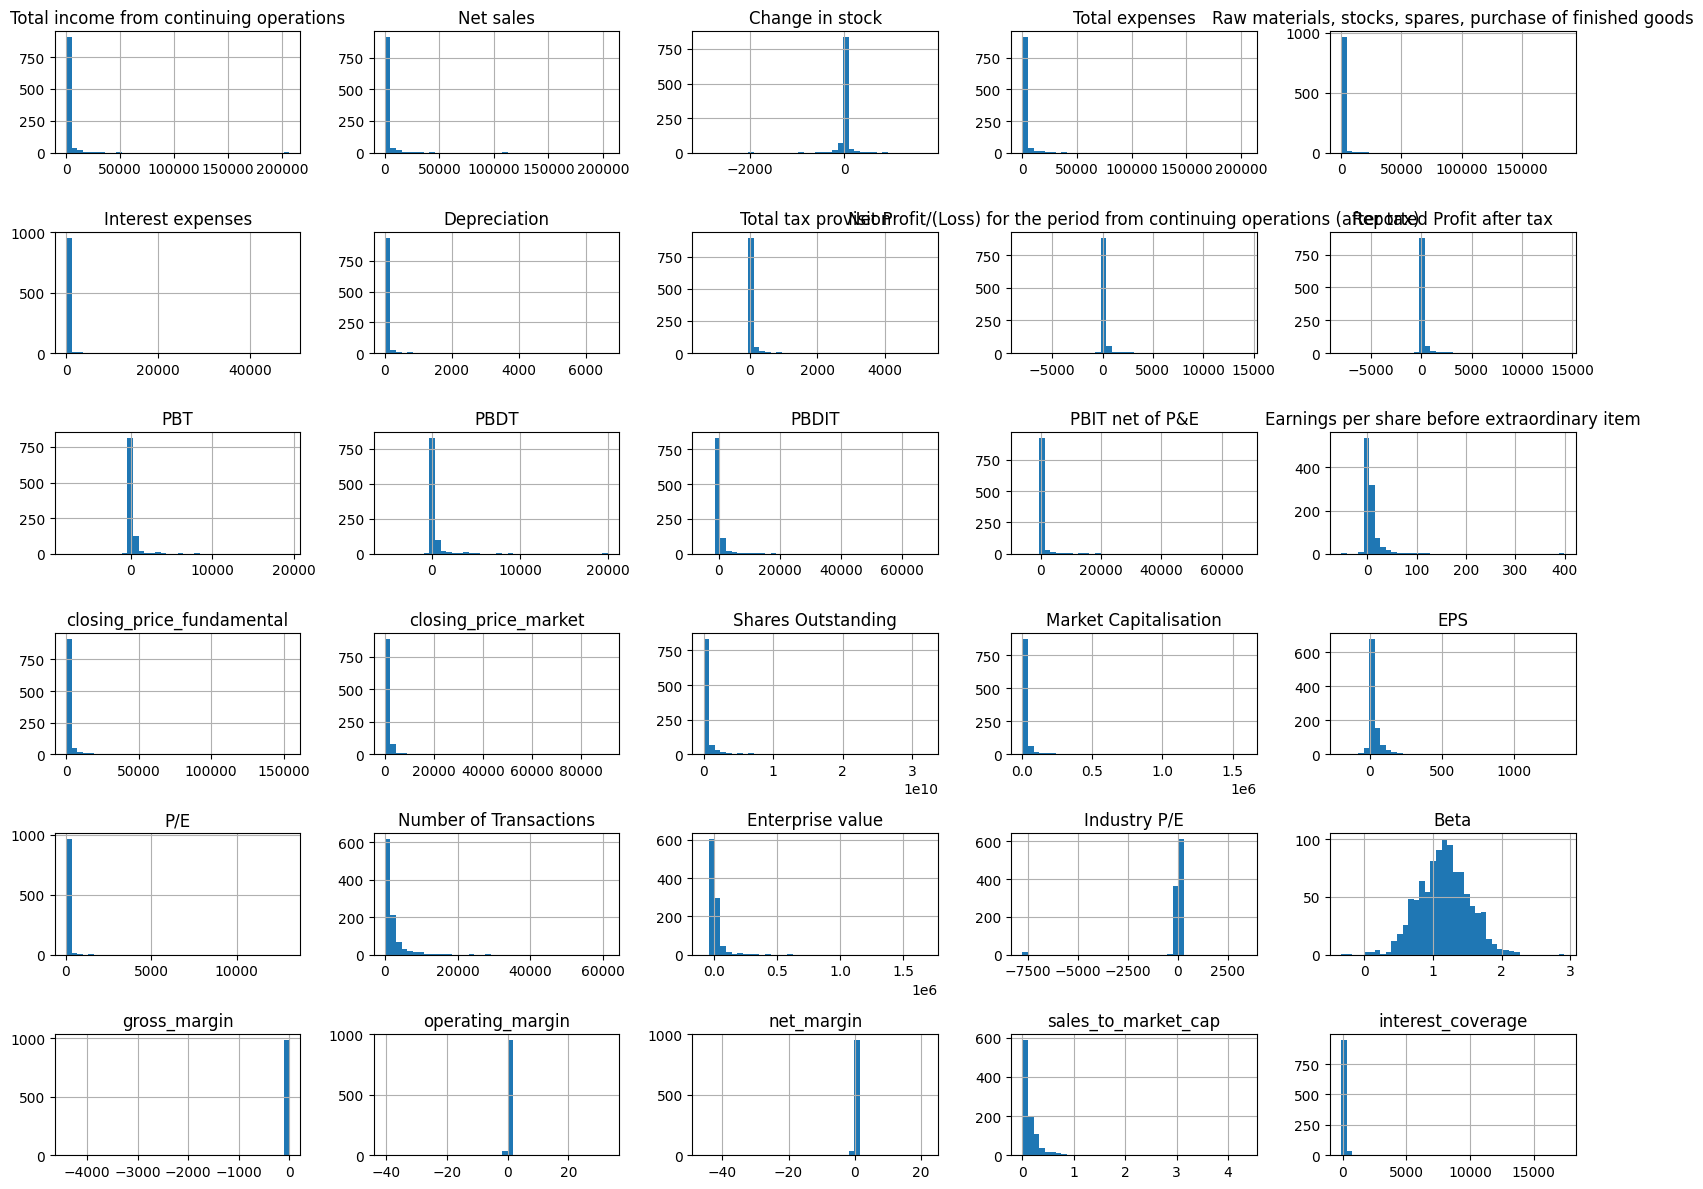

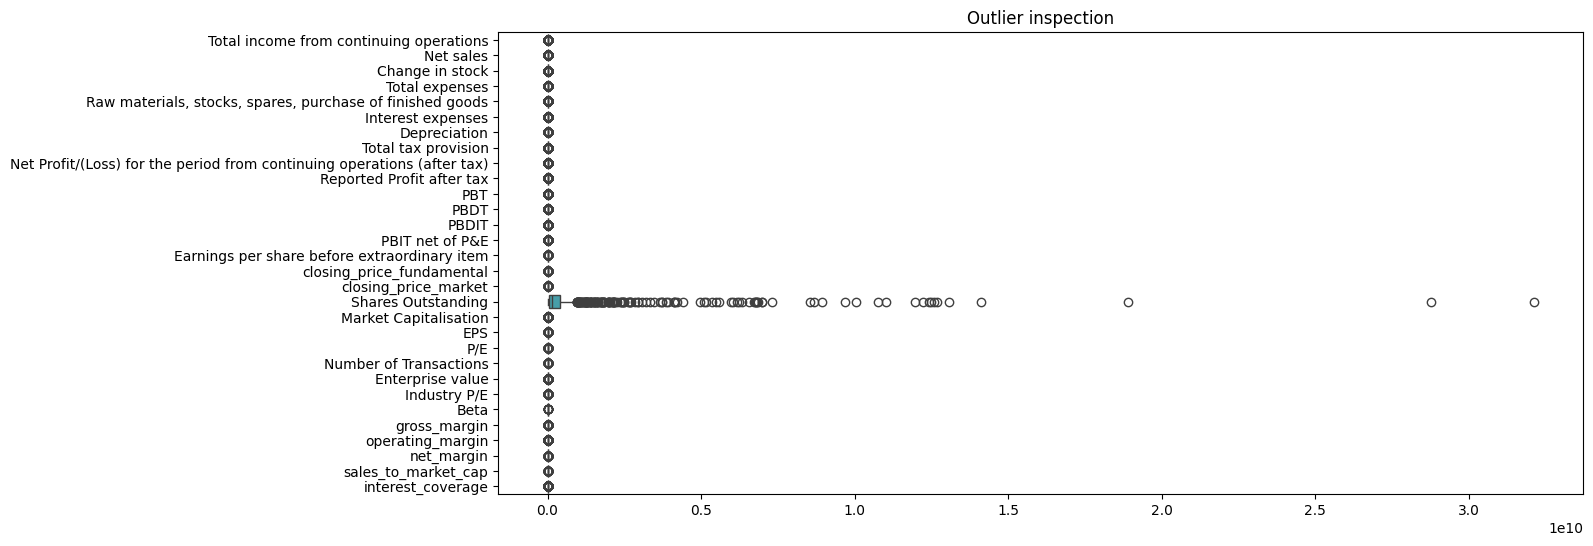

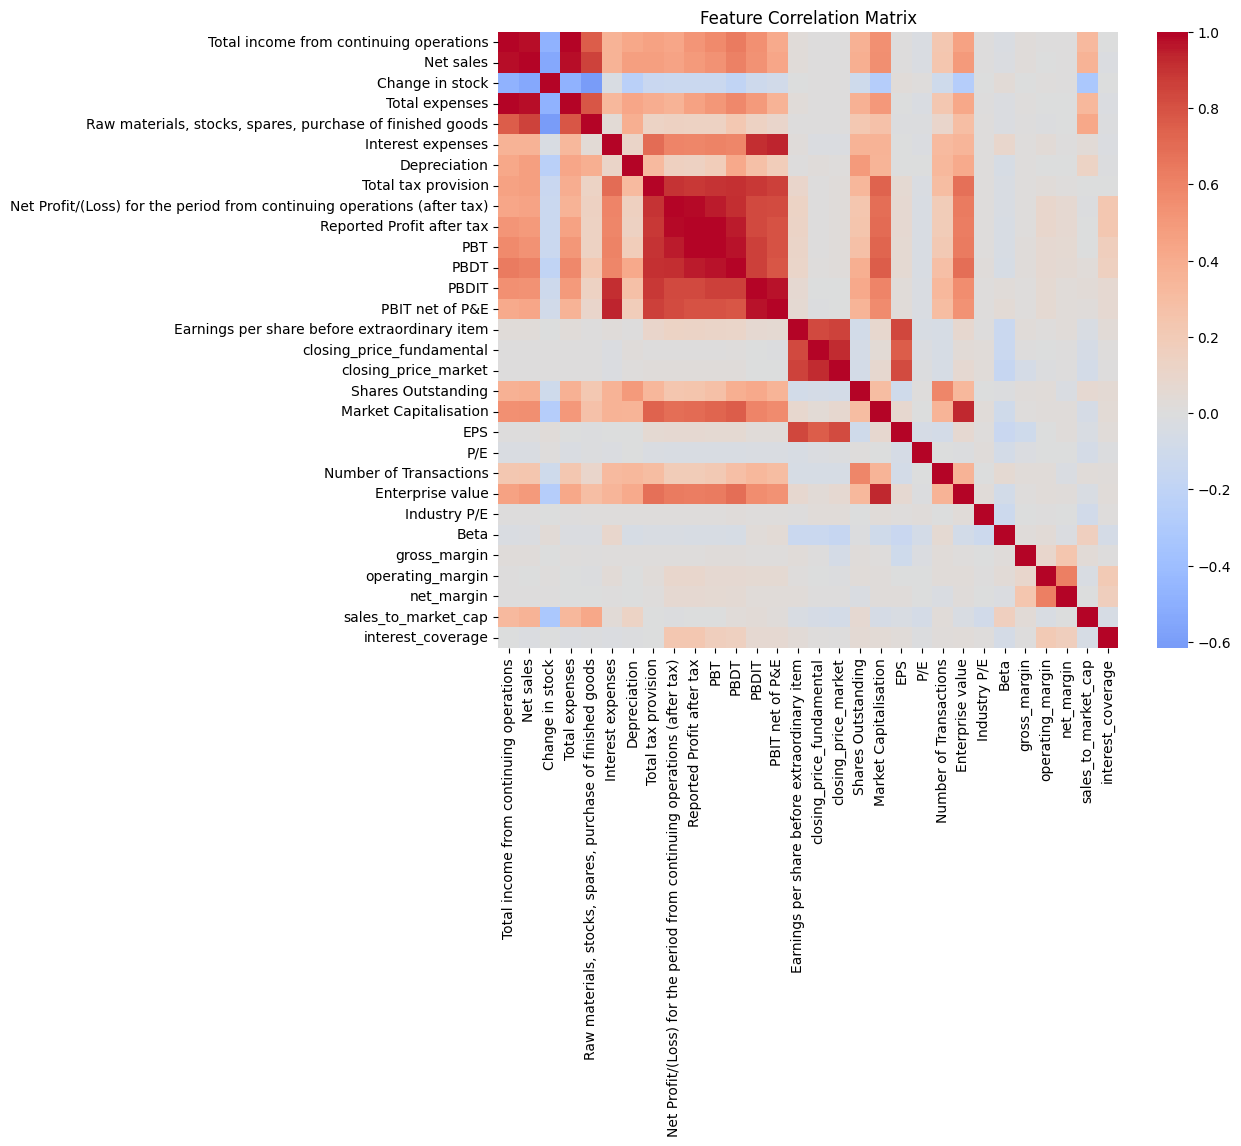


Highly correlated pairs (>0.8):
Total income from continuing operations                                  Total expenses                                                             0.997007
Reported Profit after tax                                                PBT                                                                        0.988844
Net Profit/(Loss) for the period from continuing operations (after tax)  Reported Profit after tax                                                  0.982812
Total income from continuing operations                                  Net sales                                                                  0.976212
Net sales                                                                Total expenses                                                             0.976034
PBDIT                                                                    PBIT net of P&E                                                            0.973470
PBT                      

fundamental_date                           5
firm                                       0
industry                                   0
Total income from continuing operations    0
Net sales                                  0
dtype: int64

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1. Load raw data
# =========================
raw = pd.read_csv(
    r"C:\Users\Ruhaan Singh\Desktop\wids\dataset names.csv",
    header=None
)

raw = raw.dropna(how="all")

# =========================
# 2. Fix CMIE-style headers
# =========================
HEADER_ROW = 5
raw.columns = raw.iloc[HEADER_ROW]
df = raw.iloc[HEADER_ROW + 1:].reset_index(drop=True)

# =========================
# 3. Rename identifiers
# =========================
df = df.rename(columns={
    "Company Name": "firm",
    "Industry group": "industry"
})

# =========================
# 4. Deduplicate column names
# =========================
def dedup_cols(cols):
    seen = {}
    new_cols = []
    for c in cols:
        if c in seen:
            seen[c] += 1
            new_cols.append(f"{c}.{seen[c]}")
        else:
            seen[c] = 0
            new_cols.append(c)
    return new_cols

df.columns = dedup_cols(df.columns)

# =========================
# 5. Rename duplicate Date / Price columns
# =========================
cols = list(df.columns)

date_cols = [i for i, c in enumerate(cols) if c == "Date" or c.startswith("Date.")]
price_cols = [i for i, c in enumerate(cols) if c == "Closing Price" or c.startswith("Closing Price.")]

# Assign meaning explicitly
cols[date_cols[0]] = "fundamental_date"
cols[date_cols[1]] = "price_date"

cols[price_cols[0]] = "closing_price_fundamental"
cols[price_cols[1]] = "closing_price_market"

df.columns = cols

# =========================
# 6. Parse dates correctly
# =========================
df["fundamental_date"] = pd.to_datetime(
    df["fundamental_date"], dayfirst=True, errors="coerce"
)

df["price_date"] = dayfirst=True
df["price_date"] = pd.to_datetime(
    df["price_date"], dayfirst=True, errors="coerce"
)

# =========================
# 7. Convert numeric columns
# =========================
non_numeric = ["firm", "industry", "fundamental_date", "price_date"]

for col in df.columns:
    if col not in non_numeric:
        df[col] = pd.to_numeric(df[col], errors="coerce")


#----------Dealing with missing values-----------
# Drop columns with >40% missing
threshold = 0.4
df = df.loc[:, df.isna().mean() < threshold]


ratio_cols = ["P/E", "EPS", "Beta", "Industry P/E"]

for col in ratio_cols:
    if col in df.columns:
        df[col] = df.groupby("industry")[col].transform(
            lambda x: x.fillna(x.median())
        )

fs_cols = [
    "Interest expenses",
    "Depreciation",
    "Total tax provision"
]

for col in fs_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)


numeric_cols = df.select_dtypes(include=np.number).columns

df[numeric_cols] = df[numeric_cols].fillna(
    df[numeric_cols].median()
)


df.isna().sum().sort_values(ascending=False).head()
# =========================
# 7.6 Compute financial ratios (feasible only)
# =========================

# ---- Profitability margins ----
df["gross_margin"] = (
    (df["Net sales"] - df["Raw materials, stocks, spares, purchase of finished goods"])
    / df["Net sales"]
)

df["operating_margin"] = df["PBIT net of P&E"] / df["Net sales"]

df["net_margin"] = (
    df["Net Profit/(Loss) for the period from continuing operations (after tax)"]
    / df["Net sales"]
)

df["pbt_margin"] = df["PBT"] / df["Net sales"]
df["pbdt_margin"] = df["PBDT"] / df["Net sales"]

# ---- Cash-flow proxy ----
df["cash_earnings_margin"] = df["PBDT"] / df["Net sales"]

# ---- Valuation / efficiency proxies ----
df["sales_to_market_cap"] = df["Net sales"] / df["Market Capitalisation"]
df["ev_to_sales"] = df["Enterprise value"] / df["Net sales"]

# ---- Risk / stability proxy ----
df["interest_coverage"] = df["PBIT net of P&E"] / df["Interest expenses"]

# Replace inf / -inf from division
ratio_cols_new = [
    "gross_margin", "operating_margin", "net_margin",
    "pbt_margin", "pbdt_margin", "cash_earnings_margin",
    "sales_to_market_cap", "ev_to_sales", "interest_coverage"
]

df[ratio_cols_new] = df[ratio_cols_new].replace([np.inf, -np.inf], np.nan)

# Final fill (median, conservative)
df[ratio_cols_new] = df[ratio_cols_new].fillna(
    df[ratio_cols_new].median()
)
# =========================
# 7.7 Handle correlation among computed ratios
# =========================

ratio_cols = [
    "gross_margin",
    "operating_margin",
    "net_margin",
    "pbt_margin",
    "pbdt_margin",
    "cash_earnings_margin",
    "sales_to_market_cap",
    "ev_to_sales",
    "interest_coverage"
]

# Keep only ratios that actually exist
ratio_cols = [c for c in ratio_cols if c in df.columns]

# Compute absolute correlation
corr = df[ratio_cols].corr().abs()

# Upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Identify highly correlated features
to_drop = [
    col for col in upper.columns
    if any(upper[col] > 0.85)
]

print("Dropping highly correlated ratios:", to_drop)

# Drop them
df = df.drop(columns=to_drop)

# =========================
# 8. Sanity checks
# =========================
print("Shape:", df.shape)
print("Unique firms:", df["firm"].nunique())
print("Fundamental date range:",
      df["fundamental_date"].min(),
      df["fundamental_date"].max())
print("\nInfo:")
print(df.info())

# =========================
# 9. Missing values
# =========================
print("\nMissing fraction per column:")
print(df.isna().mean().sort_values(ascending=False))




# =========================
# 10. Summary statistics
# =========================
numeric_cols = df.select_dtypes(include=np.number).columns
print("\nSummary statistics:")
print(df[numeric_cols].describe().T)

# =========================
# 11. Distributions
# =========================
df[numeric_cols].hist(bins=40, figsize=(16,12))
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))
sns.boxplot(data=df[numeric_cols], orient="h")
plt.title("Outlier inspection")
plt.show()

# =========================
# 12. Correlation analysis
# =========================
corr = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

high_corr = (
    corr.abs()
    .where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)

print("\nHighly correlated pairs (>0.8):")
print(high_corr[high_corr > 0.8])

#----------Dealing with missing values-----------
# Drop columns with >40% missing
threshold = 0.4
df = df.loc[:, df.isna().mean() < threshold]


ratio_cols = ["P/E", "EPS", "Beta", "Industry P/E"]

for col in ratio_cols:
    if col in df.columns:
        df[col] = df.groupby("industry")[col].transform(
            lambda x: x.fillna(x.median())
        )

fs_cols = [
    "Interest expenses",
    "Depreciation",
    "Total tax provision"
]

for col in fs_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)


numeric_cols = df.select_dtypes(include=np.number).columns

df[numeric_cols] = df[numeric_cols].fillna(
    df[numeric_cols].median()
)


df.isna().sum().sort_values(ascending=False).head()

